In [ ]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import nltk
import spacy

In [ ]:
#Загрузка датасета и примеры данных
df = pd.read_csv('C:/Datasets/Kaggle/Human vs AI Generated Essays/balanced_ai_human_prompts.csv')
df = df.drop_duplicates().reset_index()
print(f'Количество текстов, сгенерированных ИИ: {df.generated[df.generated == 1].count()}')
print(f'Количество рукописных текстов: {df.generated[df.generated == 0].count()}')
print(f'Пример машинного текста: \n{df[df.generated == 1].iloc[0].text[:150]}...')
print(f'Пример рукописного текста: \n{df[df.generated == 0].iloc[0].text[:150]}...')

Количество текстов, сгенерированных ИИ: 1045
Количество рукописных текстов: 1375
Пример машинного текста: 
Machine learning, a subset of artificial intelligence, has rapidly emerged as a transformative force, revolutionizing industries and redefining the po...
Пример рукописного текста: 
Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role i...


In [ ]:
# Анализ текста и добавление столбцов с длиной текста и количеством слов
df['text_length'] = df.text.str.len()
df['word_count'] = df.text.str.split().str.len()
print(f'Средняя длина текста, сгенерированного ИИ: {df[df.generated == 1].text_length.mean():.2f}')
print(f'Средняя длина текста, написанного вручную: {df[df.generated == 0].text_length.mean():.2f}')
print(f'Среднее количество слов в ИИ тексте: {df[df.generated == 1].word_count.mean():.2f}')
print(f'Среднее количество слов в рукописном тексте: {df[df.generated == 0].word_count.mean():.2f}')

Средняя длина текста, сгенерированного ИИ: 191.21
Средняя длина текста, написанного вручную: 3172.58
Среднее количество слов в ИИ тексте: 27.96
Среднее количество слов в рукописном тексте: 556.77


In [26]:
df.head()

,index,text,generated,text_length,word_count
0,0,"Machine learning, a subset of artificial intel...",1,722,96
1,1,"A decision tree, a prominent machine learning ...",1,774,103
2,2,"Education, a cornerstone of societal progress,...",1,757,93
3,3,"Computers, the backbone of modern technology, ...",1,718,92
4,4,"Chess, a timeless game of strategy and intelle...",1,827,110


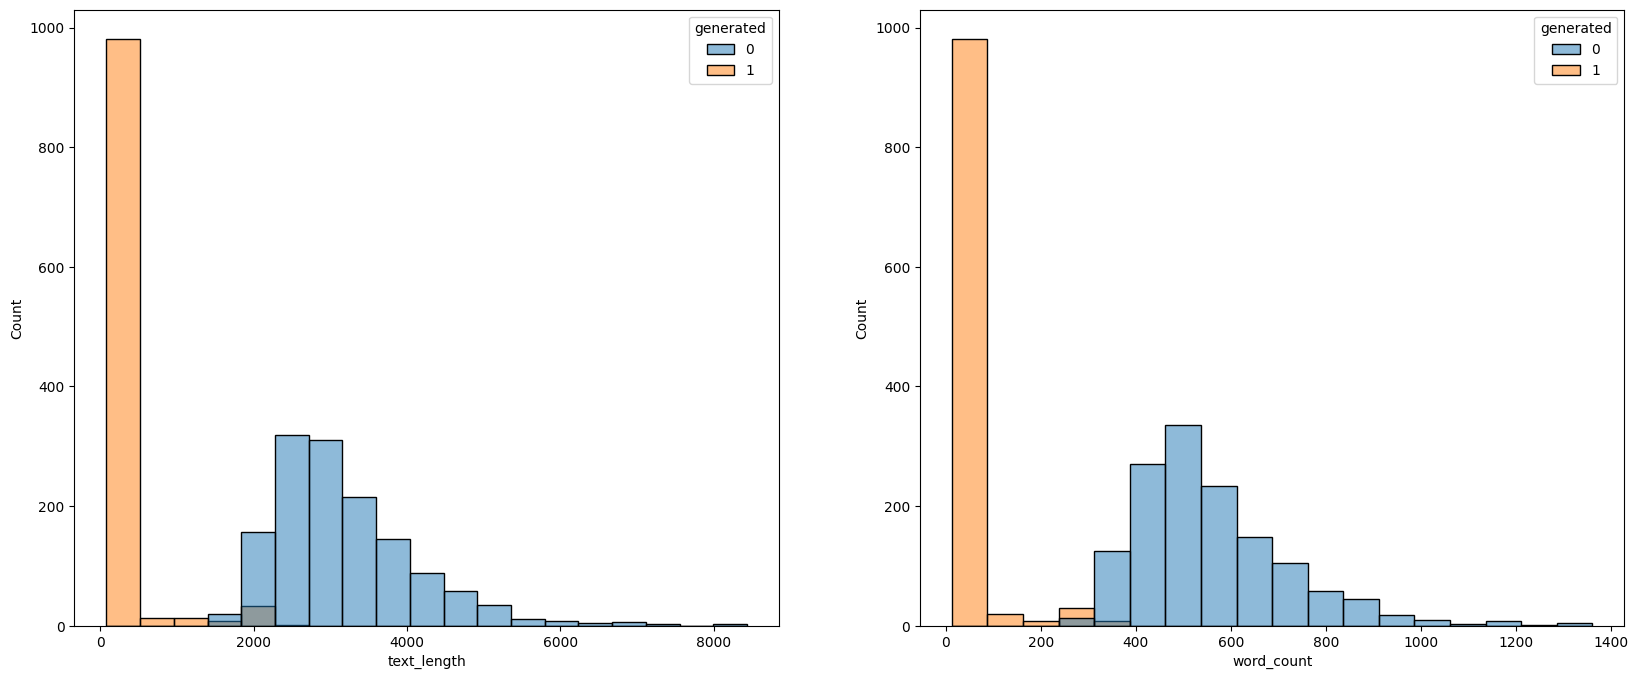

In [ ]:
#Анализ добавленных столбцов в машинном и рукописном текстах
fig,ax=plt.subplots(1,2,figsize=(20,8))
sns.histplot(df,x='text_length', hue = 'generated', ax = ax[0])
sns.histplot(df,x='word_count', hue = 'generated', ax = ax[1])
plt.show()

In [ ]:
# Подсчет количества используемых частей речи
nlp = spacy.load("en_core_web_sm")
def POS_in_text(text):
    doc = nlp(text)
    d = {}
    for word in doc:
        if word.pos_ in d:
            d[word.pos_] +=1
        else :
            d[word.pos_] = 1
    return d
df['pos_text'] = df.text.apply(POS_in_text)
df= df.join(pd.json_normalize(df['pos_text']))

# Drop the intermediate 'pos_text' column
df.drop(columns='pos_text', inplace=True)
            

In [33]:
df.columns

Index(['index', 'text', 'generated', 'text_length', 'word_count', 'NOUN',
       'PUNCT', 'DET', 'ADP', 'ADJ', 'AUX', 'ADV', 'VERB', 'CCONJ', 'PRON',
       'PART', 'SCONJ', 'PROPN', 'NUM', 'SPACE', 'X', 'INTJ'],
      dtype='object')

In [34]:
for i in df.iloc[:,4:].columns:
    print (i, spacy.explain(i))

word_count None
NOUN noun
PUNCT punctuation
DET determiner
ADP adposition
ADJ adjective
AUX auxiliary
ADV adverb
VERB verb
CCONJ coordinating conjunction
PRON pronoun
PART particle
SCONJ subordinating conjunction
PROPN proper noun
NUM numeral
SPACE space
X other
INTJ interjection


In [35]:
df.drop(columns=['SPACE', 'PUNCT'], inplace=True)

In [ ]:
# Лемматизация и приведение текста к нижнему регистру
def text_cleaning(text):
    doc = nlp(text)
    line = ''
    for word in doc:
        line +=f' {word.lemma_.lower()}'
    return line
df.text = df.text.apply(text_cleaning)

In [37]:
df.fillna(0, inplace=True)

In [38]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb


In [58]:
df.iloc[:,3:].columns

Index(['text_length', 'word_count', 'NOUN', 'DET', 'ADP', 'ADJ', 'AUX', 'ADV',
       'VERB', 'CCONJ', 'PRON', 'PART', 'SCONJ', 'PROPN', 'NUM', 'X', 'INTJ'],
      dtype='object')

In [ ]:
# Векторизация текста и добавление новых столбцов к векторизованному тексту
from scipy.sparse import hstack
y=df.generated
tf_idf = TfidfVectorizer(stop_words='english')
X = tf_idf.fit_transform(df.text)
X = hstack([X, df.iloc[:,3:]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [54]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

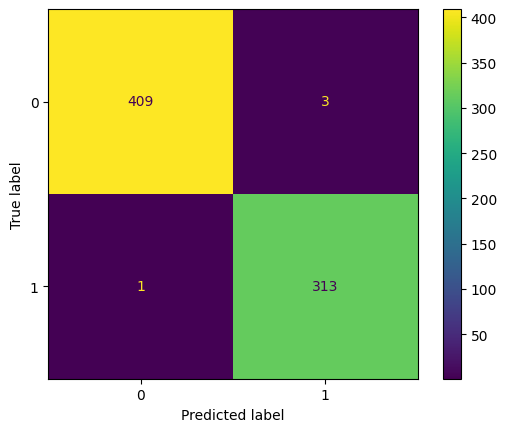

In [55]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [56]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       412
           1       0.99      1.00      0.99       314

    accuracy                           0.99       726
   macro avg       0.99      0.99      0.99       726
weighted avg       0.99      0.99      0.99       726



In [75]:
from sklearn.ensemble import GradientBoostingClassifier
parametrs={"n_estimators":[1,5,10,20,40,100, 200, 500],
           'max_depth':[3,4,5,6,10]}
clf=GradientBoostingClassifier()
grid_search_cv_clf=GridSearchCV(clf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 3, 'n_estimators': 5}

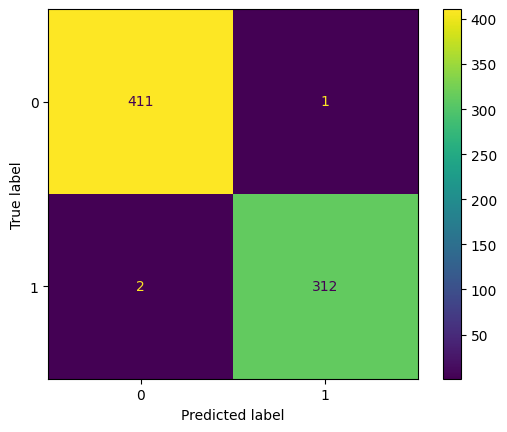

In [76]:
best_clf= grid_search_cv_clf.best_estimator_
ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test)

In [77]:
y_pred = best_clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      0.99      1.00       314

    accuracy                           1.00       726
   macro avg       1.00      1.00      1.00       726
weighted avg       1.00      1.00      1.00       726



In [ ]:
# Метод "локтя" для выявления оптимального количества деревьев
errors = []
misclassifications = []
min_err = 1
for n in range(1,64):
    rfc = RandomForestClassifier( n_estimators=n,bootstrap=True,max_features= 2)
    rfc.fit(X_train,y_train)
    preds = rfc.predict(X_test)
    err = 1 - accuracy_score(preds,y_test)
    n_missed = np.sum(preds != y_test) # Более подробно об этой строке кода см. в видео-лекции!!
    errors.append(err)
    if min_err > err :
        min_err = err
        n_estm = n
    misclassifications.append(n_missed)
n_estm

35

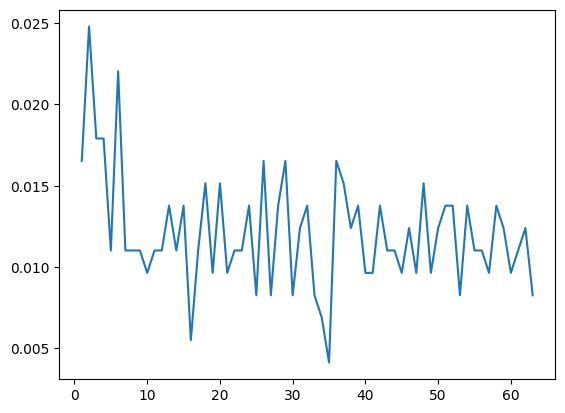

In [96]:
plt.plot(range(1,64),errors)

In [97]:
clf = RandomForestClassifier( n_estimators=35,bootstrap=True,max_features= 2)
clf.fit(X_train,y_train)
preds = clf.predict(X_test)

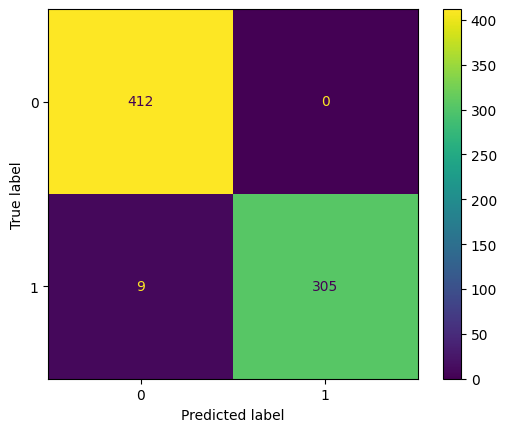

In [98]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [99]:
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       412
           1       1.00      0.97      0.99       314

    accuracy                           0.99       726
   macro avg       0.99      0.99      0.99       726
weighted avg       0.99      0.99      0.99       726



# Так как градиентный бустинг справился лучше всего, выбираем эту модель как конечную